# Word2Vec


In [5]:
# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [6]:
%load_ext autoreload
%autoreload 2

import gensim
import gensim.downloader as api
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

init_random_seed()

## Загрузка данных и подготовка корпуса

In [7]:
full_dataset = list(
    pd.read_csv(
        './stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv'
        )['input'].dropna()
)
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [8]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


In [9]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(
    train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>'
)
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]


In [10]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 648 649
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


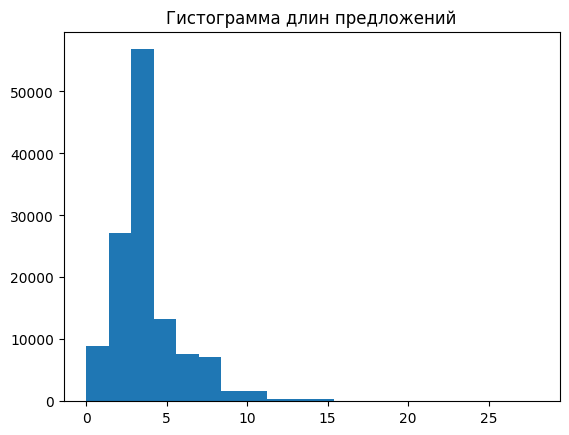

In [11]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [12]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([222,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax
   

In [13]:
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [14]:
class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)

    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN

        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

## Обучение

In [15]:
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [16]:
best_val_loss, best_model = train_eval_loop(
    trainer,
    train_dataset,
    test_dataset,
    no_loss,
    lr=1e-2,
    epoch_n=2,
    batch_size=8,
    device='cpu',
    early_stopping_patience=10,
    max_batches_per_epoch_train=2000,
    max_batches_per_epoch_val=len(test_dataset),
    lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(
        optim, patience=1, verbose=True
        )
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Эпоха 0
Эпоха: 2001 итераций, 16.03 сек
Среднее значение функции потерь на обучении 0.8888497756219756
Среднее значение функции потерь на валидации 0.8810181545394619
Новая лучшая модель!

Эпоха 1
Эпоха: 2001 итераций, 14.01 сек
Среднее значение функции потерь на обучении 0.8782604867848439
Среднее значение функции потерь на валидации 0.8774147858126166
Новая лучшая модель!



In [18]:
torch.save(trainer.state_dict(), './stepik-dl-nlp/models/sgns.pth')

In [19]:
trainer.load_state_dict(torch.load('./stepik-dl-nlp/models/sgns.pth'))

<All keys matched successfully>

## Исследуем характеристики полученных векторов

In [20]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [21]:
embeddings.most_similar('chicken')

[('chicken', 0.99993825),
 ('duck', 0.6297704),
 ('thighs', 0.6060113),
 ('breasts', 0.5968769),
 ('stock', 0.5790729),
 ('broth', 0.5466902),
 ('quarts', 0.54232544),
 ('breast', 0.53192663),
 ('sodium', 0.5221227),
 ('apart', 0.5087002)]

In [22]:
embeddings.analogy('cake', 'cacao', 'cheese')

[('emmenthal', 1.0558114),
 ('cheeses', 1.0102329),
 ('gorgonzola', 0.99502337),
 ('cottage', 0.9907776),
 ('cheese', 0.9817394),
 ('sheep', 0.9788561),
 ('glaze', 0.97642004),
 ('gruyère', 0.9652976),
 ('cacao', 0.96342397),
 ('monterey', 0.96286505)]

In [23]:
test_words = [
    'salad', 'fish', 'salmon', 'sauvignon', 'beef',
    'pork', 'steak', 'beer', 'cake', 'coffee',
    'sausage', 'wine', 'merlot', 'zinfandel',
    'trout', 'chardonnay', 'champagne', 'cacao'
]
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


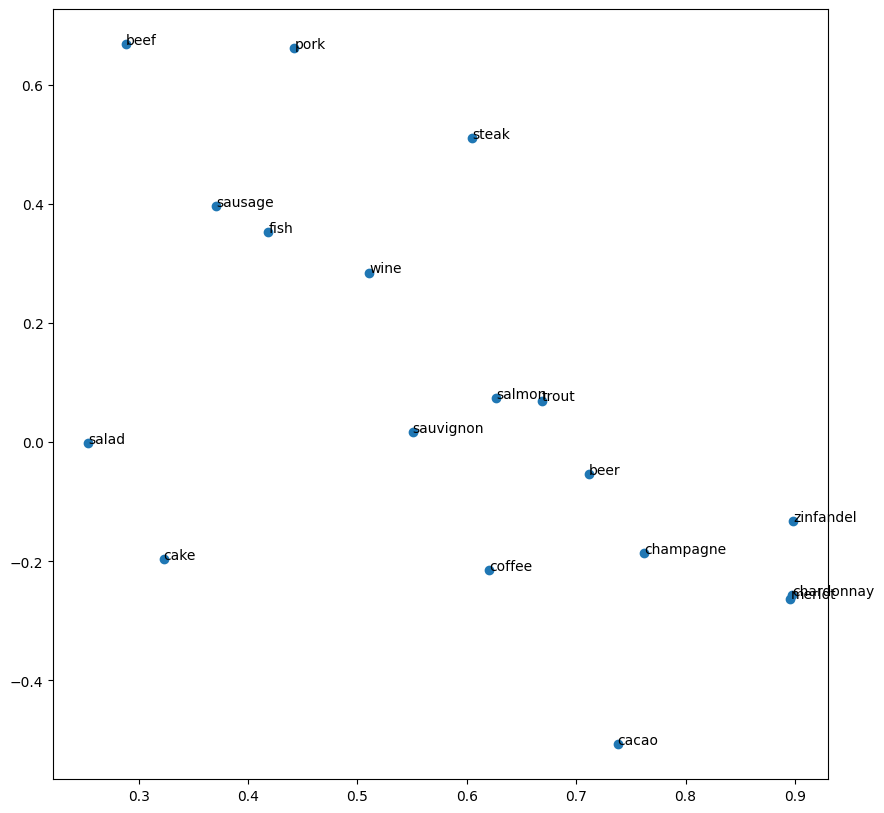

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [27]:
word2vec = gensim.models.Word2Vec(
    sentences=train_tokenized, vector_size=100,
    window=5, min_count=5, workers=4,sg=1
)

In [28]:
word2vec.wv.most_similar('chicken')

[('duck', 0.7963619828224182),
 ('turkey', 0.7351506352424622),
 ('thighs', 0.7026740908622742),
 ('simmering', 0.6993040442466736),
 ('beef', 0.6927628517150879),
 ('drumsticks', 0.6897703409194946),
 ('veal', 0.6840158104896545),
 ('breast', 0.6806832551956177),
 ('pheasant', 0.6794919371604919),
 ('wings', 0.6762094497680664)]

In [37]:
gensim_words = [w for w in test_words if w in word2vec.wv.key_to_index]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

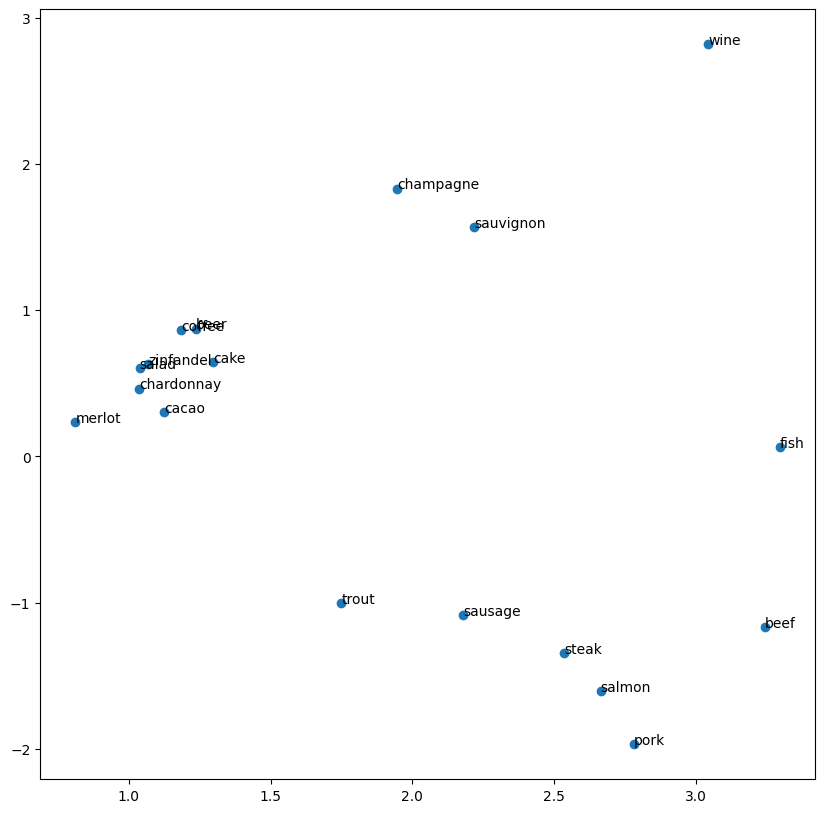

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [2]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [3]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [39]:
pretrained.most_similar('cheese')

[('cheeses', 0.7788999676704407),
 ('cheddar', 0.7627597451210022),
 ('goat_cheese', 0.7297402024269104),
 ('Cheese', 0.7286962270736694),
 ('cheddar_cheese', 0.725513756275177),
 ('Cheddar_cheese', 0.6943708658218384),
 ('mozzarella', 0.6805710792541504),
 ('cheddar_cheeses', 0.6694672107696533),
 ('Camembert', 0.6623162031173706),
 ('gruyere', 0.6615148186683655)]

In [40]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

[('woman', 0.7609435319900513),
 ('girl', 0.6139994263648987),
 ('teenage_girl', 0.6040961742401123),
 ('teenager', 0.5825759172439575),
 ('lady', 0.5752554535865784),
 ('boy', 0.5077577233314514),
 ('policewoman', 0.5066847801208496),
 ('schoolgirl', 0.5052095651626587),
 ('blonde', 0.48696190118789673),
 ('person', 0.48637545108795166)]

In [42]:
pretrained_words = [w for w in test_words if w in pretrained.key_to_index]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

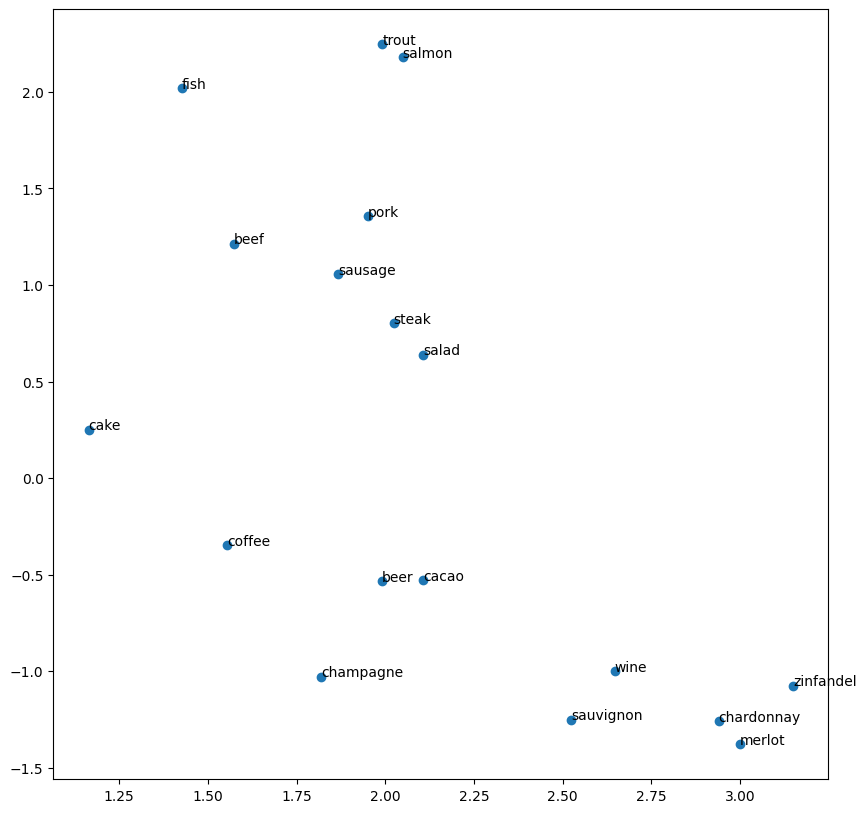

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение
* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
  - Сходство слов модель выучила неплохо
  - Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
  - Списки похожих слов отличаются!
  - Аналогии работают